# Stacked fracture azimuth plots
## KDE smoothing using seaborn

### Imports

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

## Iris data set testing

The `sns.kdeplot()` is first demonstrated with the in-built iris data set:

In [2]:
# import dataset
df_iris = sns.load_dataset('iris')

In [3]:
df_iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Two `sns.kdeplot()` are plotted on same chart by default, the two plots below demonstrate different kde bandwidths.
You can find a nice illustration of changing bandwidths [here](https://mathisonian.github.io/kde/).

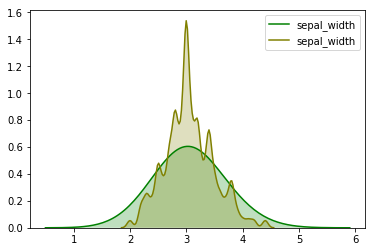

In [4]:
# Large bandwidth
sns.kdeplot(df_iris['sepal_width'], shade=True, bw=.5, color="green")
 
# Narrower bandwidth
sns.kdeplot(df_iris['sepal_width'], shade=True, bw=.05, color="olive")

We can stack figures in several ways, for instance seaborn provides the `sns.FacetGrid()` function to create just this kind of plots, however there is currently no option to pass a variable colormap to the `sns.kdeplot()`:

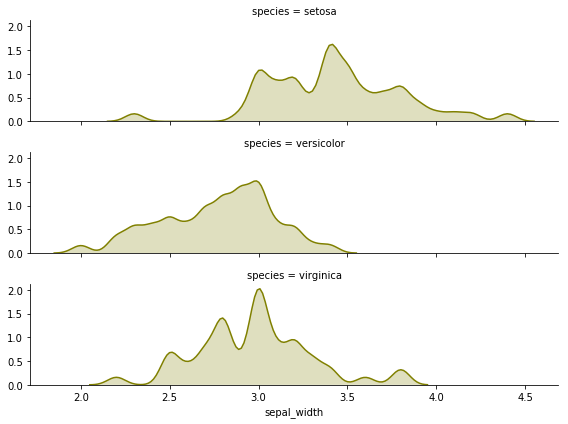

In [5]:
g = sns.FacetGrid(df_iris, row='species', height=2, aspect=4)
g.map(sns.kdeplot, 'sepal_width', shade=True, bw=0.05, color='olive')
plt.show()

A workaround to pass a colorfill to the `sns.kdeplot()` was created by [Matt Hall](https://stackoverflow.com/users/3381305/kwinkunks) and is shown below, this however could not be combined with the `sns.FacetGrid()`:

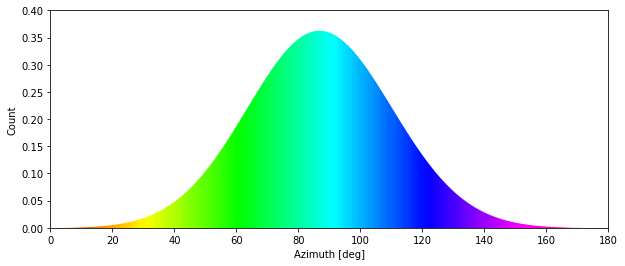

In [6]:
# Make figure
fig, ax = plt.subplots(figsize=(10, 4))

# Get input data as numpy array
data_iris = df_iris['sepal_width'].values
# Force circular by repeating one.
data_iris[-1] = data_iris[0]
# create azimuths
azis = np.linspace(0, 180, 13)
# get the y values from the kdeplot with get_lines() and get_data() on the matplotlib Axes returned by kdeplot()
_ , y = sns.kdeplot(data_iris, bw=1, lw=0).get_lines()[0].get_data()
# create the x values
x = np.linspace(0, 180, y.size)

# Make background image. This will cover the whole axis with the chosen colormap
azi_180 = np.linspace(0, 180, 181)
azi_img = np.tile(azi_180, int(max(data_iris)+1)).reshape(int(max(data_iris)+1), -1)
img = ax.imshow(azi_img, cmap='hsv', origin='lower', aspect='auto')

# Plot line using y-values from kde and masking fill.
ax.plot(x, y, lw=0)
ax.fill_between(x, y, max(data_iris)+1, color='w')

# Make labels and set limits
ax.set_xlabel("Azimuth [deg]")
ax.set_ylabel("Count")
ax.set_xlim(0,180)
ax.set_ylim(0,np.round(np.max(y)+np.max(y)*0.1, decimals=2))

plt.show()

## Building the plots with fake fracture data

### 1. Fake data and no color fill

- create fake data
- plot the data using `sns.FacetGrid()` as working proof, but without colormap

In [7]:
def create_fake_data(n_locs=5, n_orients=5):
    """
    create a fake data set for testing
    args:
        - number of locations (int)
        - number of orientations (int)
    returns:
        pandas DataFrame
    """
    # generate locations
    locations = np.arange(0,n_locs,1)

    # generate random orientations for each location
    data = {loc: 180 * np.random.ranf(size=n_locs) for loc in locations}

    # make DataFrame from data
    df_out_wide = pd.DataFrame(data)
    
    # reshape dataframe
    df_out = df_out_wide.melt()
    
    # change colum names
    df_out.rename(index=str, columns={"variable": "location", "value": "orientation"}, inplace=True)
    
    # set index
    df_out.set_index('location', drop=False, inplace=True)
    
    # cast index to string
    df_out.index = df_out.index.astype('str')
        
    return df_out

Make a fake data set using `create_fake_data()`, we use the location as an index in order to be able to slice using `pd.DataFrame.loc[]` to which we pass a `list` of locations. This is because in the real data set, the locations are floats saved as strings. Keeping them as strings is perhaps more realistic for real world locations that might be coordinates, names, tuples, etc.

The fact that we use a list also means you can repeat locations or change their ordering easily.

In [8]:
df_fracs = create_fake_data(n_locs=25, n_orients=50)
df_fracs.head()

,location,orientation
location,,
0,0,36.680625
0,0,4.446773
0,0,111.942173
0,0,81.419592
0,0,140.321647


Plot fake fracture data slice using `sns.FacetGrid()`:

In [9]:
def plot_frac_azis(df, loclist=['0', '1', '2'], bw=0.5):
    """
    plot fracture azimuths for a range of locations between start_location and end_location
    args:
        dataframe, list of locations as strings, bw
    returns:
        FacetGrid plot
    """
    # slice into Dataframe
    #df_fracs = df.iloc[np.where((df['location'] >= start_location) & (df['location'] < end_location))]
    df_fracs = df.loc[loclist]
    
    # define the plot labels
    labels = df_fracs.location.unique()
    
    # set up the FacetGrid with a given color map
    g = sns.FacetGrid(df_fracs, row='location', height=2, aspect=12)
    
    # map the sns.kdeplot onto the FacetGrid
    g.map(sns.kdeplot, 'orientation', shade=True, bw=bw, gridsize=180, color='olive')
    
    # set up plot axes, title and labels
    g.despine(top=True, right=True, left=False, bottom=False)
    g.set_axis_labels(x_var='Fracture azimuth')
    axes = g.axes.flatten()
    for ax in enumerate(axes):
        ax[1].set_ylabel(f'count: {labels[ax[0]]}')
    plt.subplots_adjust(top=0.85)
    g.fig.suptitle('Fracture orientations by locations')
    g.set_titles(row_template='')

    return g


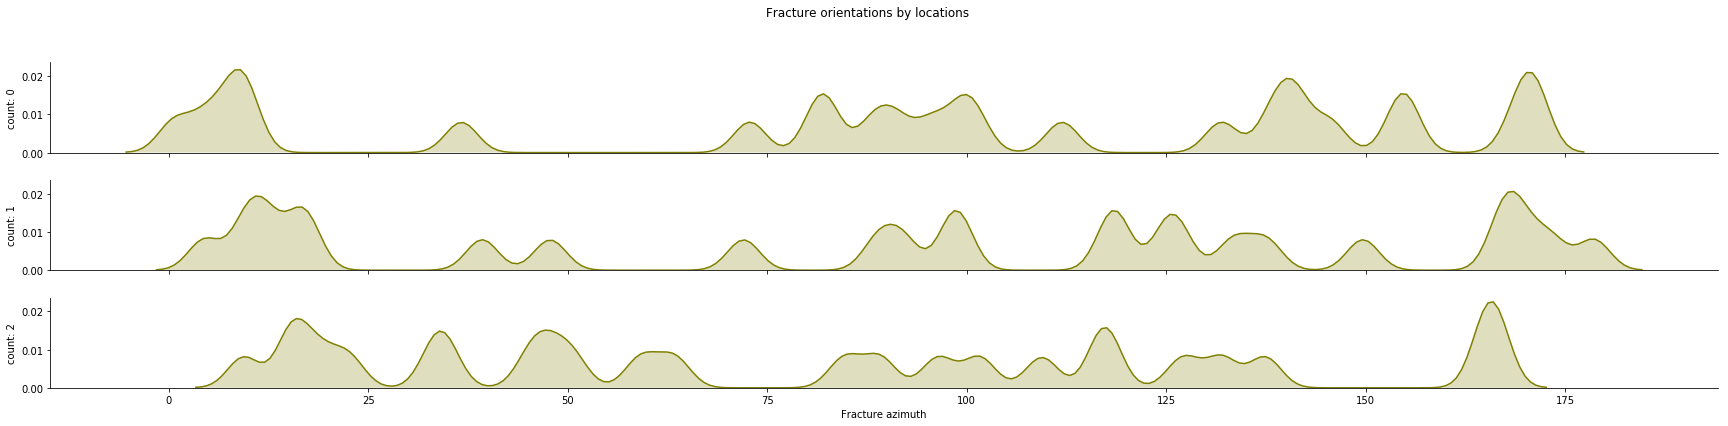

In [10]:
plot_frac_azis(df_fracs, loclist=['0','1','2'], bw=2)

### 2. Fake data and variable color fill

- use same fake data as above
- use a loop to stack the plots in a similar fashion to `sns.FacetGrid()`, but with a variable color fill using the masking method shown above

In [11]:
def make_frac_plot(ax, data_arr, bw=0.5, angle_bins=15, cmap='husl',):
    """
    makes a single kdeplot with variable color fill for a given axis and input data
    args:
        ax, data as numpy array, bw, angle bins, cmap
    returns:
        ax
    """

    # get data
    data = data_arr
    
    # set up variables and make kdeplot
    num = 180 // angle_bins + 1
    azis = np.linspace(0, 180, num=num)
    kde_ax = sns.kdeplot(data, bw=bw, lw=0, ax=ax)
    
    # get y from kdeplot ax object and make x with same size
    y = kde_ax.get_lines()[0].get_data()[1]
    x = np.linspace(0, 180, y.size)
    
    # make cmap
    cmap = ListedColormap(sns.color_palette(cmap, 256).as_hex())   

    # Make background image
    azi_180 = np.linspace(0, 180, 181)
    azi_img = np.tile(azi_180, int(max(data)+1)).reshape(int(max(data)+1), -1)
    ax.imshow(azi_img, cmap=cmap, origin='lower', aspect='auto')

    # Plot kde line and masking fill
    ax.plot(x, y, lw=0)
    ax.fill_between(x, y, max(data)+1, color='w')
    
    # Set up spines
    ax.set_xlim(0,180)
    ax.set_ylim(0, np.round(np.max(y) + np.max(y) * 0.25, decimals=2))
    
    return ax


In [12]:
def stack_frac_plots(df, loclist=['0', '1', '2'], bw=0.5,
                     angle_bins=15, axwidth=16, axheight=1,
                     x_axis_label='Azimuth [deg]', y_axes_labels='Loc',
                     cmap='husl', figtitle='Fracture azimuth plots'
                    ):
    """
    stack fracture azimuth plots
    args:
        dataframe, list of locations as strings, bw,
        angle_bins [int], axwidth [int], axheight [int],
        x and y spine labels, 
        colormap
    returns:
        ax
    """
    # set variables
    num_plots = len(loclist)
    
    # make list of orientation values for selected range
    orientations = [df.loc[location].orientation.values for location in loclist]
    # cast list to numpy array
    datasets = np.array(orientations)

    # set up figure
    fig, axs = plt.subplots(figsize=(axwidth, num_plots * axheight), nrows=num_plots, sharex=True)

    # plot in axes
    if num_plots < 2:
        print('I need at least two plots')
        ax = np.nan
    else:        
        for ax, data, i in zip(axs, datasets, range(0,num_plots)):
            ax = make_frac_plot(ax, data, bw, angle_bins, cmap)
            ax.set_ylabel(f'{y_axes_labels} {loclist[i]}')
        ax.set_xlabel(x_axis_label)
    
    # set title
    fig.suptitle(figtitle)
        
    
    return ax

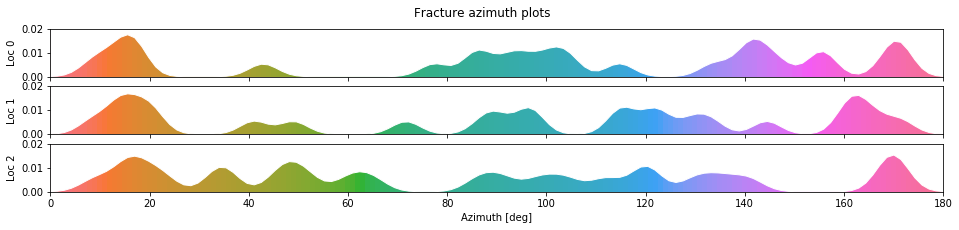

In [13]:
stack_frac_plots(df_fracs, loclist=['0', '1', '2'], bw=3)

## Apply methods to real data

### Load and clean data

In [14]:
# read real data in
df_swift_raw = pd.read_csv('../data/adam_fracs/swift_orientations.csv')
df_swift_raw.head()

,7228,7226,7227,7222,7221,7223,7499,8365,8364,8361,...,7445,7446,7447,7448,7449,7450,7451,7452,7454,7455
0,158.39,157.38,38.66,155.06,149.83,127.29,166.94,134.08,127.15,132.97,...,8.67,26.19,151.58,168.38,19.75,117.19,109.18,137.82,1.26,111.63
1,159.30,107.45,150.42,100.78,156.80,121.26,136.19,129.33,122.43,123.08,...,5.10,17.82,171.50,68.59,155.81,129.88,88.01,138.74,88.56,NaN
2,161.57,155.96,174.35,173.20,135.00,153.65,130.86,52.93,125.04,135.00,...,178.21,110.05,145.37,162.01,148.64,88.44,101.77,55.43,98.75,NaN
3,160.41,157.62,34.26,106.76,156.71,156.94,131.99,131.89,35.00,136.15,...,148.45,159.55,68.01,115.64,131.61,4.71,87.24,110.61,169.08,NaN
4,74.48,116.57,173.49,101.47,109.33,161.33,126.76,135.56,125.81,152.21,...,77.22,80.03,34.72,100.07,130.49,95.84,88.52,50.16,147.80,NaN


In [15]:
def clean_data(df):
    """
    Return a formatted dataframe for use in analysis
    args:
        - dataframe
    returns:
        - dataframe
        - array of unique variables
    """
    # clean data
    df_out = df.melt()
    df_out.sort_values('variable', inplace=True)
    df_out.dropna(inplace=True)
    df_out['variable'] = df_out['variable'].astype(float)
    df_out.rename(index=str, columns={"variable": "location", "value": "orientation"}, inplace=True)
    df_out.set_index('location', inplace=True, drop=False)
    df_out.index = df_out.index.astype('str')

    # get uniques
    uniques = np.sort(df_out['location'].unique())
    
    return df_out, uniques
    

In [16]:
df_swift, swift_uniques = clean_data(df_swift_raw)
df_swift.head()

,location,orientation
location,,
7221.0,7221.0,25.18
7221.0,7221.0,135.92
7221.0,7221.0,149.99
7221.0,7221.0,156.71
7221.0,7221.0,122.98


In [17]:
swift_uniques

array([7221. , 7222. , 7223. , 7226. , 7227. , 7228. , 7266. , 7267. ,
       7268. , 7274. , 7279. , 7280. , 7281. , 7282. , 7284. , 7432. ,
       7444. , 7445. , 7446. , 7447. , 7448. , 7449. , 7450. , 7451. ,
       7452. , 7454. , 7455. , 7499. , 7513. , 7518. , 7519. , 7522. ,
       7527. , 7528. , 7531. , 7532. , 7533. , 7557. , 7560. , 7566. ,
       7930. , 7932. , 7933. , 7936. , 7938. , 7944. , 7948. , 7950. ,
       7953. , 7955. , 7957. , 7959. , 7962. , 7964. , 7965. , 7966. ,
       7970. , 7972. , 7975. , 7976. , 7978. , 7980. , 7981. , 7984. ,
       7993. , 7997. , 7998. , 8000. , 8001. , 8002. , 8004. , 8006. ,
       8008. , 8009. , 8011. , 8012. , 8014. , 8016. , 8019. , 8020. ,
       8023. , 8024. , 8026. , 8029. , 8031. , 8032. , 8035. , 8036. ,
       8037. , 8043. , 8044. , 8046. , 8049. , 8051. , 8058. , 8060. ,
       8063. , 8076. , 8090. , 8091. , 8094. , 8097. , 8101. , 8103. ,
       8105. , 8107. , 8109. , 8110. , 8111. , 8113. , 8114. , 8115. ,
      

### Make plots with user data

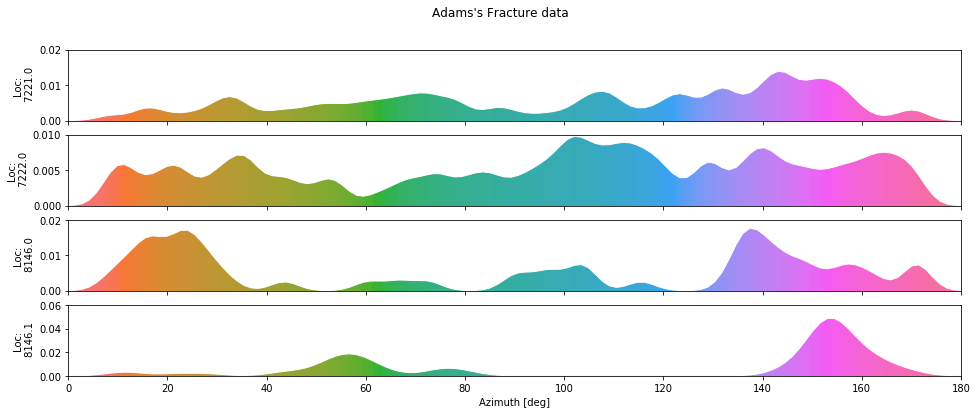

In [18]:
stack_frac_plots(df_swift, loclist=['7221.0', '7222.0', '8146.0', '8146.1'],
                 bw=3, y_axes_labels=f'Loc:\n', axheight=1.5, figtitle='Adams\'s Fracture data')
plt.show()

<hr />

<div>
<img src="https://avatars1.githubusercontent.com/u/1692321?s=50"><p style="text-align:center">© Agile Geoscience 2019</p>
</div>